In [1]:
import muse_sc as muse
import phenograph
from sklearn.decomposition import PCA
import numpy as np
from sklearn.metrics.cluster import adjusted_rand_score
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
np.random.seed(0)

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import sys
sys.executable

'/home/bokai/miniconda3/envs/muse/bin/python'

In [4]:
import pandas as pd
# only test on first 10k for sanity check
###### process protein modality

data1 = pd.read_csv("../data/livcan_counts_y4_x69.csv")
from scipy.stats import zscore
dataa = data1
dataa = dataa.apply(zscore)
dataa = dataa.to_numpy()
dataa = dataa[:10000,:]
#dataa = data1[features_names]
#dataa = dataa.drop('nucl',axis = 1)
#dataa = data1

## change to scaled version 

####### process imaging modality

datab_full = np.load('../data/single_cell_images/Inception_img_feature_liver_469.npy')
datab_full = datab_full[:10000,:]

###### this is pca on feature mod and image mod

latent_dim = 20
view_a_feature = PCA(n_components=latent_dim).fit_transform(dataa)
### this is pca on img mod
latent_dim = 100
view_b_feature = PCA(n_components=latent_dim).fit_transform(datab_full)
### then default clustering

# already finished running
view_a_label, _, _ = phenograph.cluster(view_a_feature, n_jobs = 16)
view_b_label, _, _ = phenograph.cluster(view_b_feature, n_jobs = 16)


Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.3616762161254883 seconds
Jaccard graph constructed in 4.282338380813599 seconds
Wrote graph to binary file in 0.6998188495635986 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.829738
After 6 runs, maximum modularity is Q = 0.831077
Louvain completed 26 runs in 5.167404651641846 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 13.3430757522583 seconds
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9657502174377441 seconds
Jaccard graph constructed in 4.53186559677124 seconds
Wrote graph to binary file in 0.7463877201080322 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.645882
After 19 runs, maximum modularity is Q = 0.647188
After 21 runs, maximum modularity is Q = 0.648636
Louvain completed 41 runs in 9.389973640441895 seconds
Sor

In [5]:
#view_a_label = view_a_label[:-1]
np.save('../data/museliv_a_labeltest.npy',view_a_label)
np.save('../data/museliv_b_labeltest.npy',view_b_label)
print([view_a_label.shape, view_b_label.shape])

[(10000,), (10000,)]


### change original muse function phenograph cpu allocation too many issue 

In [6]:
import numpy as np
from muse_sc.muse_architecture import structured_embedding
from scipy.spatial.distance import pdist
import phenograph
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()

def muse_fit_predict(data_x,
                     data_y,
                     label_x,
                     label_y,
                     latent_dim=100,
                     n_epochs=500,
                     lambda_regul=5,
                     lambda_super=5):
    """
        MUSE model fitting and predicting:
          This function is used to train the MUSE model on multi-modality data

        Parameters:
          data_x:       input for transcript modality; matrix of  n * p, where n = number of cells, p = number of genes.
          data_y:       input for morphological modality; matrix of n * q, where n = number of cells, q is the feature dimension.
          label_x:      initial reference cluster label for transcriptional modality.
          label_y:      inital reference cluster label for morphological modality.
          latent_dim:   feature dimension of joint latent representation.
          n_epochs:     maximal epoch used in training.
          lambda_regul: weight for regularization term in the loss function.
          lambda_super: weight for supervised learning loss in the loss function.

        Output:
          latent:       joint latent representation learned by MUSE.
          reconstruct_x:reconstructed feature matrix corresponding to input data_x.
          reconstruct_y:reconstructed feature matrix corresponding to input data_y.
          latent_x:     modality-specific latent representation corresponding to data_x.
          latent_y:     modality-specific latent representation corresponding to data_y.

        Feng Bao @ Altschuler & Wu Lab @ UCSF 2022.
        Software provided as is under MIT License.
    """

    """ initial parameter setting """
    # parameter setting for neural network
    n_hidden = 128  # number of hidden node in neural network
    learn_rate = 1e-4  # learning rate in the optimization
    batch_size = 64  # number of cells in the training batch
    n_epochs_init = 200  # number of training epoch in model initialization
    print_epochs = 50  # epoch interval to display the current training loss
    cluster_update_epoch = 200  # epoch interval to update modality-specific clusters

    # read data-specific parameters from inputs
    feature_dim_x = data_x.shape[1]
    feature_dim_y = data_y.shape[1]
    n_sample = data_x.shape[0]

    # GPU configuration
    # config = tf.ConfigProto()
    # config.gpu_options.allow_growth = True

    """ construct computation graph using TensorFlow """
    tf.reset_default_graph()

    # raw data from two modalities
    x = tf.placeholder(tf.float32, shape=[None, feature_dim_x], name='input_x')
    y = tf.placeholder(tf.float32, shape=[None, feature_dim_y], name='input_y')

    # labels inputted for references
    ref_label_x = tf.placeholder(tf.float32, shape=[None], name='ref_label_x')
    ref_label_y = tf.placeholder(tf.float32, shape=[None], name='ref_label_y')

    # hyperparameter in triplet loss
    triplet_lambda = tf.placeholder(tf.float32, name='triplet_lambda')
    triplet_margin = tf.placeholder(tf.float32, name='triplet_margin')

    # network architecture
    z, x_hat, y_hat, encode_x, encode_y, loss, \
    reconstruction_error, weight_penalty, \
    trip_loss_x, trip_loss_y = structured_embedding(x,
                                                    y,
                                                    ref_label_x,
                                                    ref_label_y,
                                                    latent_dim,
                                                    triplet_margin,
                                                    n_hidden,
                                                    lambda_regul,
                                                    triplet_lambda)
    # optimization operator
    train_op = tf.train.AdamOptimizer(learn_rate).minimize(loss)
    print('++++++++++ MUSE for multi-modality single-cell analysis ++++++++++')
    """ MUSE optimization """
    total_batch = int(n_sample / batch_size)

    with tf.Session() as sess:

        """ initialization of autoencoder architecture for MUSE """
        print('MUSE initialization')
        # global parameter initialization
        sess.run(tf.global_variables_initializer(), feed_dict={triplet_lambda: 0,
                                                               triplet_margin: 0})

        for epoch in range(n_epochs_init):
            # randomly permute samples
            random_idx = np.random.permutation(n_sample)
            data_train_x = data_x[random_idx, :]
            data_train_y = data_y[random_idx, :]

            for i in range(total_batch):
                # input data batches
                offset = (i * batch_size) % (n_sample)
                batch_x_input = data_train_x[offset:(offset + batch_size), :]
                batch_y_input = data_train_y[offset:(offset + batch_size), :]

                # initialize parameters without self-supervised loss (triplet_lambda=0)
                sess.run(train_op,
                         feed_dict={x: batch_x_input,
                                    y: batch_y_input,
                                    ref_label_x: np.zeros(batch_x_input.shape[0]),
                                    ref_label_y: np.zeros(batch_y_input.shape[0]),
                                    triplet_lambda: 0,
                                    triplet_margin: 0})

            # calculate and print loss terms for current epoch
            if epoch % print_epochs == 0:
                L_total, L_reconstruction, L_weight = \
                    sess.run((loss, reconstruction_error, weight_penalty),
                             feed_dict={x: data_train_x,
                                        y: data_train_y,
                                        ref_label_x: np.zeros(data_train_x.shape[0]),  # no use as triplet_lambda=0
                                        ref_label_y: np.zeros(data_train_y.shape[0]),  # no use as triplet_lambda=0
                                        triplet_lambda: 0,
                                        triplet_margin: 0})

                print(
                    "epoch: %d, \t total loss: %03.5f,\t reconstruction loss: %03.5f,\t sparse penalty: %03.5f"
                    % (epoch, L_total, L_reconstruction, L_weight))

        # estimate the margin for the triplet loss
        latent, reconstruct_x, reconstruct_y = \
            sess.run((z, x_hat, y_hat),
                     feed_dict={x: data_x,
                                y: data_y,
                                ref_label_x: np.zeros(data_x.shape[0]),
                                ref_label_y: np.zeros(data_y.shape[0]),
                                triplet_lambda: 0,
                                triplet_margin: 0})
        latent_pd_matrix = pdist(latent, 'euclidean')
        latent_pd_sort = np.sort(latent_pd_matrix)
        select_top_n = np.int(latent_pd_sort.size * 0.2)
        margin_estimate = np.median(latent_pd_sort[-select_top_n:]) - np.median(latent_pd_sort[:select_top_n])

        # refine MUSE parameters with reference labels and triplet losses
        for epoch in range(n_epochs_init):
            # randomly permute samples
            random_idx = np.random.permutation(n_sample)
            data_train_x = data_x[random_idx, :]
            data_train_y = data_y[random_idx, :]
            label_train_x = label_x[random_idx]
            label_train_y = label_y[random_idx]

            for i in range(total_batch):
                # data batches
                offset = (i * batch_size) % (n_sample)
                batch_x_input = data_train_x[offset:(offset + batch_size), :]
                batch_y_input = data_train_y[offset:(offset + batch_size), :]
                label_x_input = label_train_x[offset:(offset + batch_size)]
                label_y_input = label_train_y[offset:(offset + batch_size)]

                # refine parameters
                sess.run(train_op,
                         feed_dict={x: batch_x_input,
                                    y: batch_y_input,
                                    ref_label_x: label_x_input,
                                    ref_label_y: label_y_input,
                                    triplet_lambda: lambda_super,
                                    triplet_margin: margin_estimate})

            # calculate loss on all input data for current epoch
            if epoch % print_epochs == 0:
                L_total, L_reconstruction, L_weight, L_trip_x, L_trip_y = \
                    sess.run((loss, reconstruction_error, weight_penalty, trip_loss_x, trip_loss_y),
                             feed_dict={x: data_train_x,
                                        y: data_train_y,
                                        ref_label_x: label_train_x,
                                        ref_label_y: label_train_y,
                                        triplet_lambda: lambda_super,
                                        triplet_margin: margin_estimate})

                print(
                    "epoch: %d, \t total loss: %03.5f,\t reconstruction loss: %03.5f,\t sparse penalty: %03.5f,\t x triplet: %03.5f,\t y triplet: %03.5f"
                    % (epoch, L_total, L_reconstruction, L_weight, L_trip_x, L_trip_y))

        # update cluster labels based modality-specific latents
        latent_x, latent_y = \
            sess.run((encode_x, encode_y),
                     feed_dict={x: data_x,
                                y: data_y,
                                ref_label_x: label_x,
                                ref_label_y: label_y,
                                triplet_lambda: lambda_super,
                                triplet_margin: margin_estimate})

        # update cluster labels using PhenoGraph
        label_x_update, _, _ = phenograph.cluster(latent_x, n_jobs= 2)
        label_y_update, _, _ = phenograph.cluster(latent_y, n_jobs= 2)
        print('Finish initialization of MUSE')

        ''' Training of MUSE '''
        for epoch in range(n_epochs):
            # randomly permute samples
            random_idx = np.random.permutation(n_sample)
            data_train_x = data_x[random_idx, :]
            data_train_y = data_y[random_idx, :]
            label_train_x = label_x_update[random_idx]
            label_train_y = label_y_update[random_idx]

            # loop over all batches
            for i in range(total_batch):
                # batch data
                offset = (i * batch_size) % (n_sample)
                batch_x_input = data_train_x[offset:(offset + batch_size), :]
                batch_y_input = data_train_y[offset:(offset + batch_size), :]
                batch_label_x_input = label_train_x[offset:(offset + batch_size)]
                batch_label_y_input = label_train_y[offset:(offset + batch_size)]

                sess.run(train_op,
                         feed_dict={x: batch_x_input,
                                    y: batch_y_input,
                                    ref_label_x: batch_label_x_input,
                                    ref_label_y: batch_label_y_input,
                                    triplet_lambda: lambda_super,
                                    triplet_margin: margin_estimate})

            # calculate and print losses on whole training dataset
            if epoch % print_epochs == 0:
                L_total, L_reconstruction, L_weight, L_trip_x, L_trip_y = \
                    sess.run((loss, reconstruction_error, weight_penalty, trip_loss_x, trip_loss_y),
                             feed_dict={x: data_train_x,
                                        y: data_train_y,
                                        ref_label_x: label_train_x,
                                        ref_label_y: label_train_y,
                                        triplet_lambda: lambda_super,
                                        triplet_margin: margin_estimate})
                # print cost every epoch
                print(
                    "epoch: %d, \t total loss: %03.5f,\t reconstruction loss: %03.5f,\t sparse penalty: %03.5f,\t x triplet loss: %03.5f,\t y triplet loss: %03.5f"
                    % (epoch, L_total, L_reconstruction, L_weight, L_trip_x, L_trip_y))

            # update cluster labels based on new modality-specific latent representations
            if epoch % cluster_update_epoch == 0:
                latent_x, latent_y = \
                    sess.run((encode_x, encode_y),
                             feed_dict={x: data_x,
                                        y: data_y,
                                        ref_label_x: label_x,
                                        ref_label_y: label_y,
                                        triplet_lambda: lambda_super,
                                        triplet_margin: margin_estimate})

                # use PhenoGraph to obtain cluster label
                label_x_update, _, _ = phenograph.cluster(latent_x, n_jobs= 2)
                label_y_update, _, _ = phenograph.cluster(latent_y, n_jobs= 2)

        """ MUSE output """
        latent, reconstruct_x, reconstruct_y, latent_x, latent_y = \
            sess.run((z, x_hat, y_hat, encode_x, encode_y),
                     feed_dict={x: data_x,
                                y: data_y,
                                ref_label_x: label_x,  # no effects to representations
                                ref_label_y: label_y,  # no effects to representations
                                triplet_lambda: lambda_super,
                                triplet_margin: margin_estimate})

        print('++++++++++ MUSE completed ++++++++++')

    return latent, reconstruct_x, reconstruct_y, latent_x, latent_y

In [7]:
## this is just for testing

################################# loop batch version, random sample

dataa_sub = dataa[:10000,:]
datab_sub = datab_full[:10000,:]
view_a_label_sub = view_a_label[:10000]
view_b_label_sub = view_b_label[:10000]

muse_feature, reconstruct_x, reconstruct_y, \
  latent_x, latent_y = muse_fit_predict(dataa_sub,
                                        datab_sub,
                                        view_a_label_sub,
                                        view_b_label_sub,
                                        latent_dim=30,
                                        n_epochs=500,
                                        lambda_regul=5,
                                        lambda_super=5)
np.save('../data/muse_livtest.npy', muse_feature)

++++++++++ MUSE for multi-modality single-cell analysis ++++++++++
MUSE initialization
epoch: 0, 	 total loss: 1509.62451,	 reconstruction loss: 1216.46045,	 sparse penalty: 58.63280
epoch: 50, 	 total loss: 935.79700,	 reconstruction loss: 792.18951,	 sparse penalty: 28.72150
epoch: 100, 	 total loss: 753.87109,	 reconstruction loss: 699.99805,	 sparse penalty: 10.77461
epoch: 150, 	 total loss: 699.65332,	 reconstruction loss: 686.82532,	 sparse penalty: 2.56560
epoch: 0, 	 total loss: 978.73059,	 reconstruction loss: 847.29163,	 sparse penalty: 0.39098,	 x triplet: 13.25992,	 y triplet: 12.63689
epoch: 50, 	 total loss: 802.45410,	 reconstruction loss: 699.30096,	 sparse penalty: 0.57777,	 x triplet: 10.08797,	 y triplet: 9.96488
epoch: 100, 	 total loss: 791.40527,	 reconstruction loss: 691.60693,	 sparse penalty: 0.48871,	 x triplet: 9.77240,	 y triplet: 9.69856
epoch: 150, 	 total loss: 787.68195,	 reconstruction loss: 689.32465,	 sparse penalty: 0.42817,	 x triplet: 9.65275,	 y 

In [1]:
import anndata as ad
import scanpy as sc 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
muse_feature = np.load('../data/muse_livtest.npy')
df_meta = pd.read_csv("../data/livcan_meta_y4_x69_withClusters_0327.csv")
df = pd.DataFrame(muse_feature)
# second batch
df_meta = df_meta.iloc[:10000,:]
adata = ad.AnnData(df)
sc.pp.scale(adata)
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')
sc.tl.umap(adata)

/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
a = np.load('../data/museliv_a_labeltest.npy') # clusters from feature
b = np.load('../data/museliv_b_labeltest.npy') # clusters from image

/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'a'}, xlabel='UMAP1', ylabel='UMAP2'>

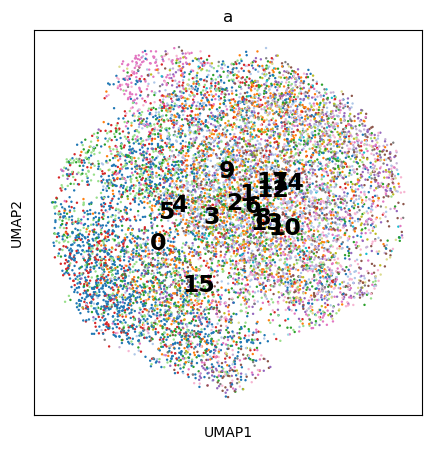

In [4]:
plt.rcParams["figure.figsize"] = (5, 5)
adata.obs['a'] = [str(i) for i in a]
sc.pl.umap(adata, color='a', legend_fontsize=17, show=False, palette='tab20',
          legend_loc= 'on data')

/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'b'}, xlabel='UMAP1', ylabel='UMAP2'>

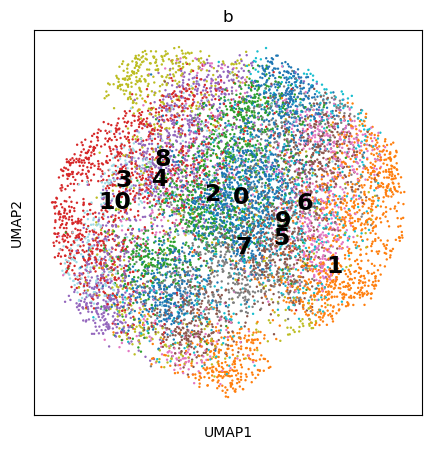

In [5]:
plt.rcParams["figure.figsize"] = (5, 5)
adata.obs['b'] = [str(i) for i in b]
sc.pl.umap(adata, color='b', legend_fontsize=17, show=False, palette='tab20',
          legend_loc= 'on data')

Same observation as the cHL dataset. Embedding favors morphology clusters and probably subpar.

Consider reach to authors to improve the results.